In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

cap = cv2.VideoCapture('monitoring.avi')
# take first frame of the video
ret,frame = cap.read()
# setup initial location of window
r,h,c,w = 250,90,400,125 # simply hardcoded the values
track_window = (c,r,w,h)
# set up the ROI for tracking
roi = frame[r:r+h, c:c+w]
hsv_roi = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
mask = cv2.inRange(hsv_roi, np.array((0., 80.,32.)), np.array((10.,250.,250.)))
roi_hist = cv2.calcHist([hsv_roi],[0],mask,[180],[0,180])
cv2.normalize(roi_hist,roi_hist,0,255,cv2.NORM_MINMAX)
# Setup the termination criteria, either 10 iteration or move by atleast 1 pt
term_crit = ( cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 1 )
while(1):
    ret ,frame = cap.read()
    
    if ret == True:
        hsv = cv2.cvtColor(frame, cv2.COLOR_BGR2HSV)
        dst = cv2.calcBackProject([hsv],[0],roi_hist,[0,180],1)
# apply meanshift to get the new location
        ret, track_window = cv2.CamShift(dst, track_window, term_crit)
# Draw it on image
        pts = cv2.boxPoints(ret)
        pts = np.int0(pts)
        img2 = cv2.polylines(frame,[pts],True, 255,2)
        cv2.imshow('img2',img2)
        k = cv2.waitKey(60) & 0xff
        if k == 27:
            break
        else:
            cv2.imwrite(chr(k)+".jpg",img2)
    else:
        break
cv2.destroyAllWindows()
cap.release()


C:\Users\Several\AppData\Local\Temp\ipykernel_6596\1454712315.py:29: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  pts = np.int0(pts)


469


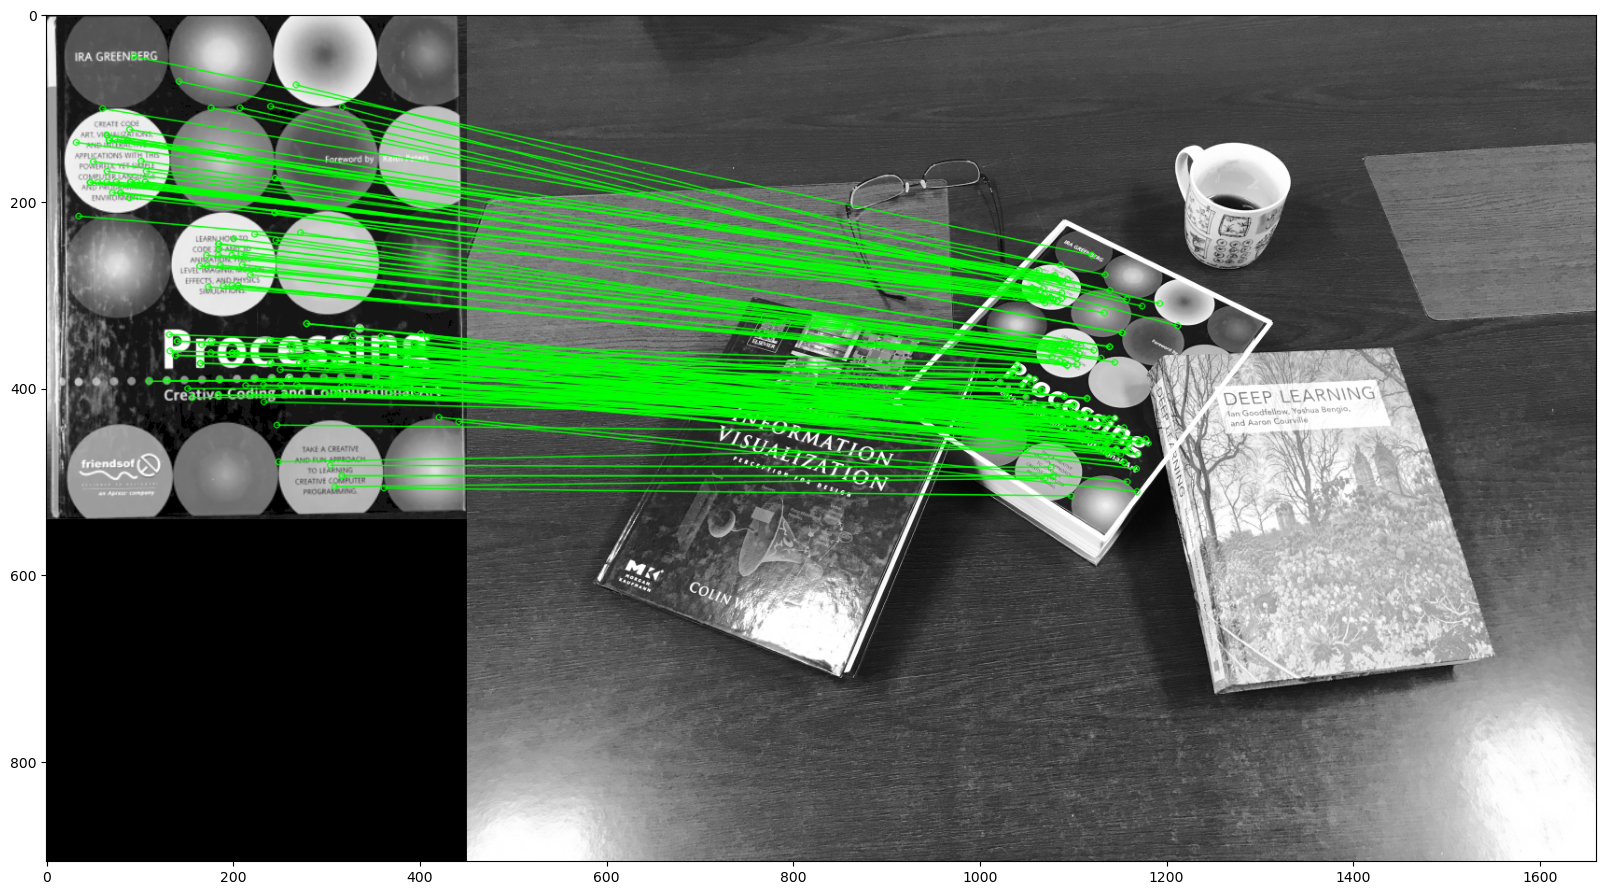

(<matplotlib.image.AxesImage at 0x29785d7a050>, None)

In [9]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

img1 = cv2.imread('book.png', 0) # queryImage
img2 = cv2.imread('books.jpg', 0) # trainImage
# Initiate SIFT detector
sift = cv2.SIFT_create()
# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1,None)
kp2, des2 = sift.detectAndCompute(img2,None)

FLANN_INDEX_KDTREE = 0
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.9*n.distance:
        good.append(m)

MIN_MATCH_COUNT = 10
print(len(good))

if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    h,w = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)
else:
    print("Not enough matches are found - %d/%d" % (len(good),MIN_MATCH_COUNT))
    matchesMask = None
draw_params = dict(matchColor = (0,255,0), singlePointColor = None, matchesMask = matchesMask, flags = 2)
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)
plt.figure(figsize = (20,20))
plt.imshow(img3, 'gray'),plt.show()